In [2]:
# adding clips from video to training set using predictions

# pull video
# predict some section
#   perhaps using the 5 min bin predictions from the original model
#   perhaps randomly sample
# user label clips as scratch, not scratch - any of the possible clip categories
# if clip label-able, write to correct directory


In [3]:
from model_loading import *
from prediction import *
from model_validation import *

/Users/rebeccakrall/miniconda3/envs/tf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
in_training_set = "/Users/rebeccakrall/Desktop/PRX_03_Validation_Sheet_in_training_set.csv"
model_path = "/Users/rebeccakrall/Data/MoViNet Models After Jan 2025/Models/scratch_120624" 


In [ ]:
model_specs, data_specs = load_seg_model_data(model_path)
model_specs['checkpoint_path'] = '/Users/rebeccakrall/Data/MoViNet Models After Jan 2025/Models/scratch_120624/scratch_120624_checkpoints/cp_02.ckpt'
model = load_seg_model_weights(model_specs)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [69]:
vid_csv = pd.read_csv(in_training_set)
row = vid_csv.iloc[0,:]

In [70]:
video_path = os.path.join(row['Folder Path'], row['File Name'])
crop_specs = determine_crop_specs(video_path, 6)
predictions, fps = predict_video(model, data_specs, video_path, crop_specs, row['Animal ID'], row['Scoring Start (min)'], row['Scoring End (min)'])

pred_file = "/Users/rebeccakrall/Desktop/prediction_0_ch2.pkl"
with open(pred_file, 'wb') as f:
    pickle.dump(predictions, f)

opened cap
   1799/Unknown - 2694s 1s/step

2025-02-21 15:03:59.343043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-02-21 15:03:59.343284: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[movinet_classifier_1/movinet_1/block4_layer0/bneck/feature/stream_buffer_21/zeros/Const/_13]]
2025-02-21 15:03:59.343290: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4566881837858758776
2025-02-21 15:03:59.343294: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5909239105384605163
2025-02-21 15:03:59.343298: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1007265157732837223
2025-02-21 15:03:59.343301: I tensorflow/core/framework/local_rendezvous.cc:422] Local 

1799/1799 [==============================] - 2694s 1s/step


In [64]:
model_specs

{'checkpoint_dir': '/Users/rebeccakrall/Data/MoViNet Models After Jan 2025/Models/scratch_120624/scratch_120624_checkpoints',
 'checkpoint_path': '/Users/rebeccakrall/Data/MoViNet Models After Jan 2025/Models/scratch_120624/scratch_120624_checkpoints/cp_02.ckpt',
 'model_id': 'a0',
 'resolution': 172,
 'batch_size': 8,
 'num_frames': 30,
 'num_classes': 1,
 'loss_name': None,
 'learning_rate': 0.0001,
 'class_labels': {'Scratch': 0, 'Not Scratch': 1}}

In [72]:
window = 1
avg, counts = rolling_analysis(predictions, window)
off = np.mean(predictions[predictions > 0])
on = np.mean(predictions[predictions < 0])

starts = {}
# a = np.where((avg >= (0.80 * off)) & (counts == 0))
# b = np.where((avg <= (0.80 * on)) & (counts == 1))
# starts['high_off'] = a[0]
# starts['high_on'] = b[0]

c = np.where((avg >= (0.3 * off)) & (avg < (0.70 * off)) &  (counts == 0))
d = np.where((avg <= (0.3 * on)) & (avg > (0.70 * on)) & (counts == 1))
starts['mid_off'] = c[0]
starts['mid_on'] = d[0]

e = np.where((avg >= 0) & (avg < (0.4 * off)) & (counts == 0))
f = np.where((avg <= 0) & (avg > (0.4 * on)) & (counts == 1))
starts['low_off']= e[0]
starts['low_on'] = f[0]

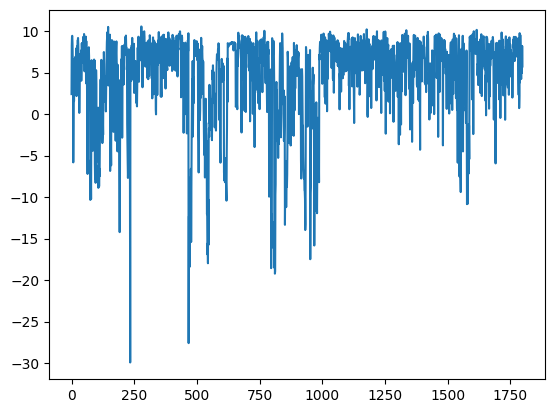

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(predictions )
# plt.plot(counts)
plt.show()

In [ ]:
# window refers to the number of PREDICTIONS, so if 30 frames are used to predict, window = 2 will pull 60 frames.
temp_folder = "/Users/rebeccakrall/Desktop/Behavior Add 2"

bins = 10
# num_clips = 10
clip_path = "/Users/rebeccakrall/Desktop/Behavior Clips"
labels = [x for x in os.listdir(clip_path) if '.DS' not in x]


# Determine necessary parameters to get appropriate video clips
circles, vid_frames, fps, _ = get_params_from_vid(video_path)
frame_delay = row['Scoring Start (min)'] * 60 * fps
center = circles[row['mouse id']]
cap = cv2.VideoCapture(video_path)

# Determine sets of frames of high, medium, and low confidence labeling
# starts = find_starts_by_confidence(logits, window)
# starts, counts = find_starts_bins(predictions, window, bins = bins)


# iterate through the different 'confidence' levels for each label
for ind,(k,v) in enumerate(starts.items()):
    # print(f'Evaluating Bin: {ind} with {counts[ind]} videos')
    print(f'Evaluating Bin: {ind} with {len(v)} videos')
    # choose a subset of clips
    # if len(list(v)) > num_clips:
    #     sample_options = list(v) # this needs to be shuffled then popped
    #     random.shuffle(sample_options)
    #     start_sample = []
    #     # count = 0

    #     while (len(start_sample) < num_clips) and (len(sample_options) != 0):
    #         # samp = random.sample(list(v),1)
    #         samp = sample_options.pop(0)
    #         if all([abs(x - samp) > window for x in start_sample]):
    #             start_sample.append(samp)

    #     start_sample = random.sample(list(v), num_clips)
    # else:
    #     start_sample = list(v)
    # start_sample.sort()

    # wrong = 0
    # total = 0
    
    # iterate through the clip starts
    for s in v:
        e = s+window
        # Determine the clips 'confidence' i.e. proportion of frames labeled 1 
        confidence = sum(predictions[s:e] < 0) / window ## THIS LINE WILL NEED TO CHANGE IF DOING MULTI-LABEL

        # Get the clip, show it to the user, prompt them to choose 
        clip = grab_clip_with_annotation(cap, s, window, predictions, data_specs['num_frames'], center, 300, frame_delay, add_text = False)
        user_label = show_clip_grab_input(clip, labels, f'{labels[int(np.round(confidence))]}', delay = 33)

        # if the user actually labeled the clip, determine if it was labeled wrong
        # add it to dictionary of clips
        if user_label:
            # total = total + 1
            fn = row['File Name']+ '_'+ row['mouse id']+ '_'+ str(s* data_specs['num_frames']) +'_'+ str(e* data_specs['num_frames'])+ '.mp4'
            os.makedirs(os.path.join(temp_folder, labels[int(user_label)]), exist_ok = True)
            save_path = os.path.join(os.path.join(temp_folder, labels[int(user_label)]), fn)
            write_clip(clip, save_path, fps, clip[0].shape[:2])

            # user_labled_clips[labels[int(user_label)]].append(clip)


        cv2.destroyAllWindows()
        cv2.waitKey(1)


cap.release()

Evaluating Bin: 0 with 229 videos


/var/folders/ch/m9j8_ntd13l1fhyf0w__ydsr0000gp/T/ipykernel_45444/3329291882.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  user_label = show_clip_grab_input(clip, labels, f'{labels[int(np.round(confidence))]}', delay = 33)


Saved: /Users/rebeccakrall/Desktop/Behavior Add 2/Turn Right/PRX_03_Run_3_Computer_1_D12_Males_16DEC22.mp4_m6_0_30.mp4
Saved: /Users/rebeccakrall/Desktop/Behavior Add 2/Not Scratch/PRX_03_Run_3_Computer_1_D12_Males_16DEC22.mp4_m6_360_390.mp4
Saved: /Users/rebeccakrall/Desktop/Behavior Add 2/Not Scratch/PRX_03_Run_3_Computer_1_D12_Males_16DEC22.mp4_m6_870_900.mp4
Saved: /Users/rebeccakrall/Desktop/Behavior Add 2/Not Scratch/PRX_03_Run_3_Computer_1_D12_Males_16DEC22.mp4_m6_960_990.mp4
Saved: /Users/rebeccakrall/Desktop/Behavior Add 2/Not Scratch/PRX_03_Run_3_Computer_1_D12_Males_16DEC22.mp4_m6_1170_1200.mp4
Saved: /Users/rebeccakrall/Desktop/Behavior Add 2/Face Grooming/PRX_03_Run_3_Computer_1_D12_Males_16DEC22.mp4_m6_2010_2040.mp4
Saved: /Users/rebeccakrall/Desktop/Behavior Add 2/Rearing/PRX_03_Run_3_Computer_1_D12_Males_16DEC22.mp4_m6_3810_3840.mp4
Saved: /Users/rebeccakrall/Desktop/Behavior Add 2/Face Grooming/PRX_03_Run_3_Computer_1_D12_Males_16DEC22.mp4_m6_3960_3990.mp4
Saved: /User

: 

In [16]:
os.makedirs(os.path.join(temp_folder, labels[int(user_label)]), exist_ok = True)

In [20]:
os.path.join(os.path.join(temp_folder, labels[int(user_label)]), fn)

'/Users/rebeccakrall/Desktop/Behavior Adds/Right Foot Scratch/PRX_03_Run_3_Computer_1_D12_Males_16DEC22.mp4_m6_157_159.mp4'

In [34]:
for fold in os.listdir(temp_folder):
    if fold != '.DS_Store':
        print(fold)
        for file in os.listdir(os.path.join(temp_folder, fold)):
            print(file.split('_')[-2])
            start = int(file.split('_')[-2]) * data_specs['num_frames']
            end = start + ((window-1) * data_specs['num_frames'])

            new_fn = '_'.join(file.split('_')[:-2]) + '_' + str(start) + "_" + str(end) + ".mp4"
            os.rename(os.path.join(temp_folder, fold, file), os.path.join(temp_folder, fold, new_fn))

Rear On Wall
208
207
1798
350
Left Foot Scratch
232
1577
1584
1585
233
1583
614
619
1582
618
615
593
111
108
608
611
610
788
609
234
109
110
1581
107
1580
613
616
620
1579
617
612
1578
594
Not Scratch
20
1083
30
97
37
1690
326
38
547
32
1029
18
327
252
243
11
446
397
1269
240
28
1390
60
79
70
348
349
41
328
1431
1084
165
36
723
1685
459
689
235
711
65
359
31
335
1352
1362
938
10
722
1389
61
163
35
917
721
205
677
841
1071
57
1668
162
9
Face Grooming
447
135
944
538
82
537
536
134
201
448
202
175
67
597
84
548
184
195
185
199
104
83
132
86
170
535
791
847
171
168
942
133
136
130
85
113
166
183
197
873
820
66
479
196
518
167
131
940
Dog Shake
678
Rearing
679
354
656
837
622
657
355
686
Turn Right
247
380
998
39
245
660
6
7
Walking
400
999
739
375
Right Foot Scratch
1549
469
925
154
1548
542
855
858
859
854
546
543
1546
155
158
924
468
472
477
77
974
985
540
979
94
978
541
984
476
473
971
96
968
952
933
93
156
860
857
852
190
809
980
810
545
75
544
811
798
981
853
191
856
157
926
932
969


In [47]:
fps

29.989525548942627